This notebook illustrates the way to run the simulations and perform some basic analyses with the output H5 files. The parameters used for these simulations are those reported in the paper `Insights from the quantitative calibration of an elasto-plastic model
from a Lennard-Jones atomic glass. Castellanos et al. Comptes Rendus. Physique, Volume 22 (2021) no. S3, pp. 135-162`. See [here](https://comptes-rendus.academie-sciences.fr/physique/item/10.5802/crphys.48.pdf).

As detailed in the publication, the parameter values were obtained by optimizing these mesoscale simulation results against a set of reference molecular dynamics simulations in the stationary flow regime. The reader is referred to the publication for details.

NOTE: in the publication, the results use a higher shear angle resolution. This behavior can be recovered by increasing the `n_theta` parameter.

In [1]:
import os
import numpy as np
import multiprocessing
from tqdm import tqdm
from math import pi as pi
import pandas as pd
from itertools import groupby
import glob
import h5py 
import matplotlib.pyplot as plt

# Run the simulations

Here we run the simulations using the configuration file `gallery/espci/python/stationary_state_opt.cfg` that contains the optimal parameters for simulating the stationary state of the reference molecular dynamics simulations, as reported in the publication mentioned above. 

MEPLS can run in parallel out of the box thanks to OpenMP, and the number of threads used is defined by the environment variable `OMP_NUM_THREADS`. We set the value to the number of available CPUs and run the executable with the mentioned config file.

In [2]:
exec_file = '<path-to-MEPLS-exec-file>'
config_file = './stationary_state_opt.cfg'

n_threads = multiprocessing.cpu_count()

In [ ]:
os.system(f'export OMP_NUM_THREADS={n_threads} && {exec_file} -f {config_file}')

# Analyse the macroscale response

Here we analyze the macroscale response using the discrete driving events dataset located at `/AQS/driving_events` within the output H5 files hierarchy. This is the most granular data available since it is composed of individual events representing the external stress increments and drops. The former corresponds to external load increments, while the latter to drops induced by plastic deformation occurring under a fixed external strain. (see `gallery/espci/python/run_and_process_transient.ipynb` for an alternative way to produce stress-strain curves).

In [4]:
def generate_stress_strain_meso(filenames, **kwd):

    """
    This generator provides stress-strain curves of mesoscale data    
    """    

    for filename in tqdm(filenames):
        
        try:
            file = h5py.File(filename,'r')
            
            driving_ = np.array(file['/AQS/driving_events'])        
            file.close()
            
            driving_df = pd.DataFrame(driving_, columns=driving_.dtype.names).set_index('index')        
            driving_df['total_strain'] = np.cumsum(driving_df.dtotal_strain.values)
            driving_df['gamma'] = 2. * driving_df['total_strain'] # convert epsilon to gamma
            driving_df['ext_stress'] = np.cumsum(driving_df.dext_stress.values)
            driving_df['pressure'] = np.cumsum(driving_df.dpressure.values)
            
            w = (driving_df['gamma']>=2*kwd['eps0'])&(driving_df['gamma']<2*kwd['eps1'])
            driving_df = driving_df[w]
            
            driving_df['sample'] = filename
            
            # find stress drops carefully. Some macroscale drops are actually positive, but this is a fringe case
            # that occurs only when some patch-scale thresholds are negative (as explained in the publication)
            # and the system size is very small, typically smaller than what we care about
            w = np.logical_not( (driving_df['activation_protocol']==0)&(driving_df['dext_stress']>0.) )
            df = driving_df[['activation_protocol','dext_stress','dpressure']][w]
            
            # remove initial load increment (e.g., if we applied a sudden initial load such as in creep)
            df = df.iloc[1:]
            
            # now we don't care about dataframe index, we reset it to get the natural one
            df = df.reset_index()
            
            D_ext_stress = list()
            for i, group in groupby(df[['activation_protocol','dext_stress','dpressure']].values, key=lambda x: x[0]):
                sum_ext_stress = np.sum([x[1] for x in group]) # sum of dext_stress
                D_ext_stress.append( [i,sum_ext_stress] )
            D_ext_stress = np.vstack(D_ext_stress)
    
            w_drops = D_ext_stress[:,0] == 0
            w_incr = D_ext_stress[:,0] == 2
            
            # stress rises due to loading incremetns and drops due to avalanches
            drops_ext_stress = - 1 * D_ext_stress[:,1][w_drops]
            increments_ext_stress = D_ext_stress[:,1][w_incr]
    
            yield {'values': driving_df, 
                   'drops': drops_ext_stress, 
                   'increments': increments_ext_stress}
        
        except Exception as ex:
            print(ex)
            continue
        

In [5]:
def make_histogram(data, nbins=80, a=None, b=None, density=True, log=False, edges=None, filter_zeros=False):

    if a is None: a = min(data)
    if b is None: b = max(data)    
    if edges is None: 
        if log: edges = np.logspace(np.log10(a),np.log10(b),nbins,base=10)
        else: edges = np.linspace(a,b,nbins)
        
    hist, edges = np.histogram(data, edges, density=density)

    edges = edges[:-1]
    
    if filter_zeros:
        w = hist > 0
        hist = hist[w]
        edges = edges[w]
        
    return edges, hist

## Load macroscale response

In [6]:
meso_filenames = glob.glob('./*h5')

In [ ]:
data_generator = generate_stress_strain_meso(meso_filenames, eps0=0., eps1=5.)
data = list(data_generator)

## Make plots

Text(0, 0.5, 'PDF(stress_xy increment)')

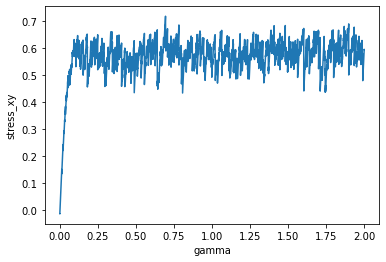

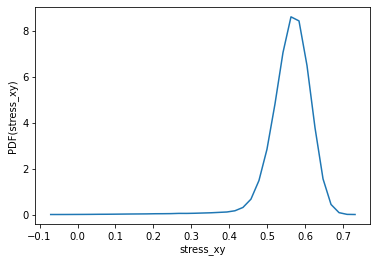

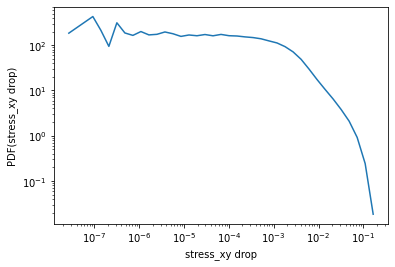

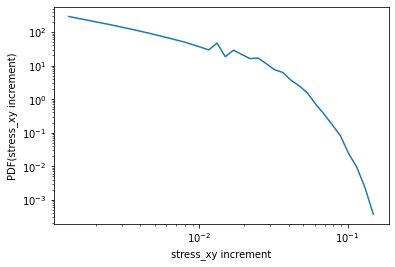

In [8]:
df = data[0]['values']
x = df['gamma'].values
y = df['ext_stress'].values
plt.figure()
plt.plot(x, y)
plt.xlabel('gamma')
plt.ylabel('stress_xy')

stress_strain_df = pd.concat([d['values'] for d in data])
x, y = make_histogram(stress_strain_df['ext_stress'].values, nbins=40, filter_zeros=True)
plt.figure()
plt.plot(x, y)
plt.xlabel('stress_xy')
plt.ylabel('PDF(stress_xy)')

drops = np.hstack([d['drops'] for d in data])
x, y = make_histogram(drops,log=True,nbins=40, filter_zeros=True)
plt.figure()
plt.loglog(x, y)
plt.xlabel('stress_xy drop')
plt.ylabel('PDF(stress_xy drop)')

increments = np.hstack([d['increments'] for d in data])
x, y = make_histogram(increments,log=True,nbins=40, filter_zeros=True)
plt.figure()
plt.loglog(x, y)
plt.xlabel('stress_xy increment')
plt.ylabel('PDF(stress_xy increment)')


# Local mesoscale response

Here we analyze the local patch response. For that, we use the datasets that contain the results of the local shear tests located at `/snapshots/patches` within the output H5 files hierarchy. The tests are applied to patches extracted from different locations, with different shear orientations `alpha`, and on patches with different radii `R`. See the publication mentioned above for further details.

In [9]:
def process_local_stress_df_meso(df):

    """
    Create the quantities of interest for the analysis based on the raw simulation results.
    """
    
    df['ss_resolved'] = 0.5*(df['ss_11']-df['ss_00'])*np.sin(2*df['theta']*pi/180.) + df['ss_01']*np.cos(2*df['theta']*pi/180.)
    df['oi_resolved'] = 0.5*(df['oi_11']-df['oi_00'])*np.sin(2*df['theta']*pi/180.) + df['oi_01']*np.cos(2*df['theta']*pi/180.)
    df['ee_resolved'] = 0.5*(df['ee_11']-df['ee_00'])*np.sin(2*df['theta']*pi/180.) + df['ee_01']*np.cos(2*df['theta']*pi/180.)
      
    df['gamma'] = 2. * df['oi_eps']
      
    # to compute the local stress drop tensorial components, we rotate the tensors to have then in the system alingned with the 
    # applied shear test. In that case, when we compute the slip angle, we automatically have the difference between the 
    # angle of applied shear and the actual drop direction
    a = df['theta']*pi/180
    ee_01_ = 0.5*(df['ee_11']-df['ee_00'])*np.sin(2*a) + df['ee_01']*np.cos(2*a)  
    ee_00_ = df['ee_00']*np.cos(a)**2 + df['ee_11']*np.sin(a)**2 + df['ee_01']*np.sin(2*a)
    ee_11_ = df['ee_00']*np.sin(a)**2 + df['ee_11']*np.cos(a)**2 - df['ee_01']*np.sin(2*a)   
    oi_01_ = 0.5*(df['oi_11']-df['oi_00'])*np.sin(2*a) + df['oi_01']*np.cos(2*a)  
    oi_00_ = df['oi_00']*np.cos(a)**2 + df['oi_11']*np.sin(a)**2 + df['oi_01']*np.sin(2*a)
    oi_11_ = df['oi_00']*np.sin(a)**2 + df['oi_11']*np.cos(a)**2 - df['oi_01']*np.sin(2*a)   
      
    drop_xx = oi_00_.values - ee_00_.values
    drop_yy = oi_11_.values - ee_11_.values
    drop_xy = oi_01_.values - ee_01_.values
    df['slip_angle'] = 0.5*np.arctan2(-0.5*(drop_xx-drop_yy), drop_xy)*180/pi
      
    df = df.rename( columns={'ss_00':'nonrot_ss_pxx', 'ss_11':'nonrot_ss_pyy', 'ss_01':'nonrot_ss_pxy', 
                               'oi_00':'nonrot_oi_pxx', 'oi_11':'nonrot_oi_pyy', 'oi_01':'nonrot_oi_pxy', 
                               'ee_00':'nonrot_ee_pxx', 'ee_11':'nonrot_ee_pyy', 'ee_01':'nonrot_ee_pxy',  
                               'theta': 'Alpha',
                               'ref_element': 'PatchID'
                               } )
    df['resolved_shear'] = df['ss_resolved']
    df['vm_stress'] = np.sqrt((0.5)*(0.5*np.power(df['nonrot_ss_pxx']-df['nonrot_ss_pyy'].values,2.)+2*np.power(df['nonrot_ss_pxy'],2.)))
    df['dev_angle'] = 0.5*np.arctan2(-0.5*(df['nonrot_ss_pxx'].values-df['nonrot_ss_pyy'].values), df['nonrot_ss_pxy'].values)*180/pi
    df['threshold'] = df['oi_resolved']
    df['barrier'] = df['oi_resolved']-df['ss_resolved']
    df['stress_drop'] = df['oi_resolved']-df['ee_resolved']
    df['shear_modulus'] = df['barrier'] / df['gamma']
    df['p_ss'] = -(df['nonrot_ss_pxx']+df['nonrot_ss_pyy'])/2. 
    df['p_threshold'] = -(df['nonrot_oi_pxx']+df['nonrot_oi_pyy'])/2. 
    df['p_barrier'] = df['p_threshold'] - df['p_ss']
    df['p_drop'] = df['p_threshold'] - (-1)*(df['nonrot_ee_pxx']+df['nonrot_ee_pyy'])/2.
    
    df['Epot_el']  = df['ss_pe_el'] 
    df['Epot_conf']  = df['ss_pe_conf'] 
    df['Epot_total']  = df['ss_pe_el'] + df['ss_pe_conf']
    
    return df

In [10]:
def generate_meso_patch_stress(meso_filenames, **kwargs):

    """
    This generator provides local stress data at the PATCH SCALE obtained from
    mesoscale simulations by locally probing the system
    """
    

    eps0 = kwargs['eps0']
    eps1 = kwargs['eps1']
    N_patch_list =  kwargs['N_patch_list']
    scale_factor = kwargs['scale_factor']

    for filename in tqdm(meso_filenames):  

        file = h5py.File(filename,'r') 

        T = file.attrs['temperature_liquid']
            
        try:
            for group in file['snapshots/patches'].values():
                assert(group.attrs['monitor_magnitude'].decode('UTF-8')=='total_strain')
                snapshot_attrs = {k:v for k,v in group.attrs.items()}            
                if snapshot_attrs['recorded_target'] >= eps0 and snapshot_attrs['recorded_target'] <= eps1 and snapshot_attrs['N_patch'] in N_patch_list:
                    data = np.array(group)
                    df = pd.DataFrame(data, columns=data.dtype.names)
                    
                    df = process_local_stress_df_meso(df)

                    df['N_patch'] = snapshot_attrs['N_patch']
                    
                    # create a unique identifier for the samples
                    seed = filename.split('/')[-1].split('seed_')[-1].split('.')[0]
                    n_rep = group.name.split('_')[-1]
                    df['sample'] = seed+'_'+n_rep

                    df['R'] = df['N_patch'] * scale_factor
                    df['T'] = T
                    
                    yield df
                
        except Exception as ex:
            print('poblem with ', filename)
            print(ex)
            continue

        file.close()

    return        

In [ ]:
data_generator = generate_meso_patch_stress(meso_filenames, eps0=0.5, eps1=5., N_patch_list=[1,2,4,8], scale_factor=7.5/2)
data = list(data_generator)

df = pd.concat(data)

## Local thresholds

### PDF of thresholds

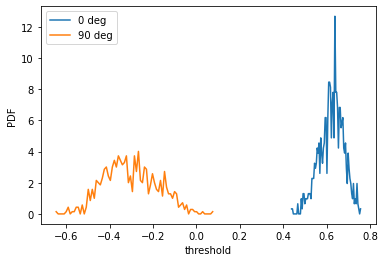

In [12]:
plt.figure()

w = (df['Alpha']==0.)&(df['R']==30)
x, y = make_histogram(df[w]['threshold'].values)
plt.plot(x, y, label='0 deg')

w = (df['Alpha']==90.)&(df['R']==30)
x, y = make_histogram(df[w]['threshold'].values)
plt.plot(x, y, label='90 deg')

plt.xlabel('threshold')
plt.ylabel('PDF')
plt.legend()

### Average threshold vs patch radius

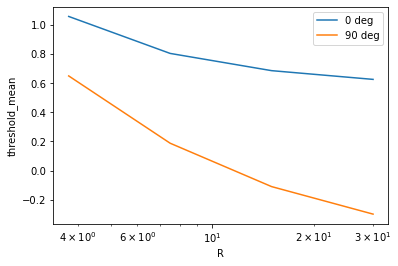

In [13]:
agg = df.groupby(['R', 'Alpha'], as_index=False)['threshold'].mean()

plt.figure()

w = agg['Alpha']==0.
x = agg[w]['R'].values
y = agg[w]['threshold'].values
plt.plot(x, y, label='0 deg')

w = agg['Alpha']==90.
x = agg[w]['R'].values
y = agg[w]['threshold'].values
plt.plot(x, y, label='90 deg')

plt.gca().set_xscale('log')
plt.xlabel('R')
plt.ylabel('threshold_mean')
plt.legend()

### Average threshold vs shear angle

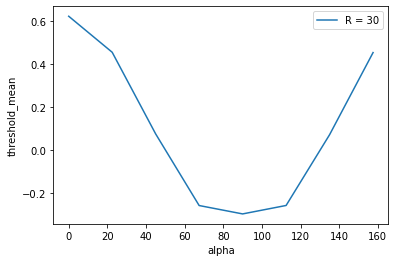

In [14]:
agg = df[df['R']==30].groupby('Alpha', as_index=False)['threshold'].mean()

plt.figure()

x = agg['Alpha'].values
y = agg['threshold'].values
plt.plot(x, y, label='R = 30')

plt.xlabel('alpha')
plt.ylabel('threshold_mean')
plt.legend()

## Local barriers

### PDF of barriers

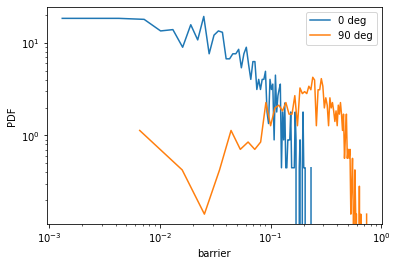

In [15]:
plt.figure()

w = (df['Alpha']==0.)&(df['R']==30)
x, y = make_histogram(df[w]['barrier'].values)
plt.loglog(x, y, label='0 deg')

w = (df['Alpha']==90.)&(df['R']==30)
x, y = make_histogram(df[w]['barrier'].values)
plt.loglog(x, y, label='90 deg')

plt.xlabel('barrier')
plt.ylabel('PDF')
plt.legend()

### Average barrier vs patch radius

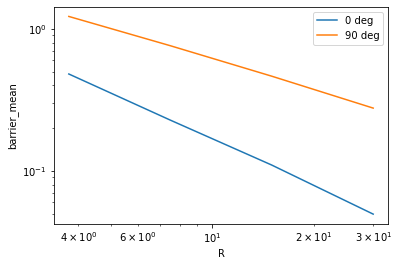

In [16]:
agg = df.groupby(['R', 'Alpha'], as_index=False)['barrier'].mean()

plt.figure()

w = agg['Alpha']==0.
x = agg[w]['R'].values
y = agg[w]['barrier'].values
plt.loglog(x, y, label='0 deg')

w = agg['Alpha']==90.
x = agg[w]['R'].values
y = agg[w]['barrier'].values
plt.loglog(x, y, label='90 deg')

plt.gca().set_xscale('log')
plt.xlabel('R')
plt.ylabel('barrier_mean')
plt.legend()

### Average barrier vs shear angle

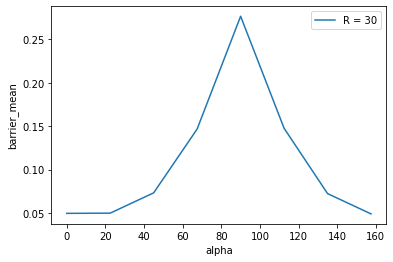

In [17]:
agg = df[df['R']==30].groupby('Alpha', as_index=False)['barrier'].mean()

plt.figure()

x = agg['Alpha'].values
y = agg['barrier'].values
plt.plot(x, y, label='R = 30')

plt.xlabel('alpha')
plt.ylabel('barrier_mean')
plt.legend()

## Local stress drops

### PDF of stress drops

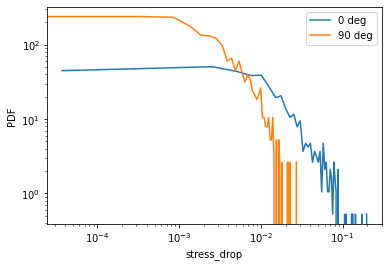

In [18]:
plt.figure()

w = (df['Alpha']==0.)&(df['R']==30)
x, y = make_histogram(df[w]['stress_drop'].values)
plt.loglog(x, y, label='0 deg')

w = (df['Alpha']==90.)&(df['R']==30)
x, y = make_histogram(df[w]['stress_drop'].values)
plt.loglog(x, y, label='90 deg')

plt.xlabel('stress_drop')
plt.ylabel('PDF')
plt.legend()

### Average stress drops vs patch radius

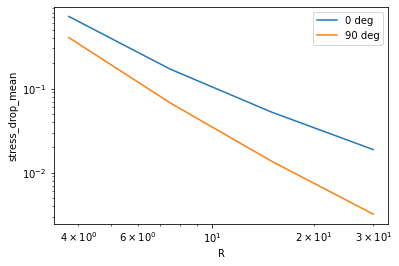

In [19]:
agg = df.groupby(['R', 'Alpha'], as_index=False)['stress_drop'].mean()

plt.figure()

w = agg['Alpha']==0.
x = agg[w]['R'].values
y = agg[w]['stress_drop'].values
plt.loglog(x, y, label='0 deg')

w = agg['Alpha']==90.
x = agg[w]['R'].values
y = agg[w]['stress_drop'].values
plt.loglog(x, y, label='90 deg')

plt.gca().set_xscale('log')
plt.xlabel('R')
plt.ylabel('stress_drop_mean')
plt.legend()

### Average stress drops vs shear angle

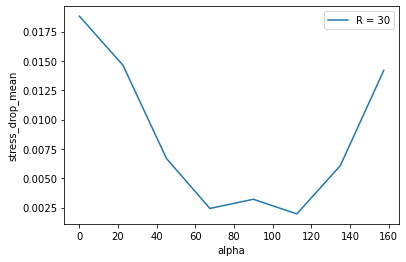

In [20]:
agg = df[df['R']==30].groupby('Alpha', as_index=False)['stress_drop'].mean()

plt.figure()

x = agg['Alpha'].values
y = agg['stress_drop'].values
plt.plot(x, y, label='R = 30')

plt.xlabel('alpha')
plt.ylabel('stress_drop_mean')
plt.legend()